In [4]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

As an example we will take the minimization of a quadratic function from the Tensorflow Probability page.

In [5]:
# A high-dimensional quadratic bowl.
ndims = 60
minimum = np.ones([ndims], dtype='float64')
scales = np.arange(ndims, dtype='float64') + 1.0

# The objective function and the gradient.
def quadratic_loss_and_gradient(x):
    return tfp.math.value_and_gradient(
        lambda x: tf.reduce_sum(
        scales * tf.math.squared_difference(x, minimum), axis=-1),
        x)
start = np.arange(ndims, 0, -1, dtype='float64')
optim_results = tfp.optimizer.lbfgs_minimize(
    quadratic_loss_and_gradient,
    initial_position=start,
    num_correction_pairs=10,
    tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)

In [6]:
print(optim_results.position)

tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(60,), dtype=float64)


Now we do a version with a loss function involving a tensorflow model

In [7]:
gen = tf.keras.models.load_model("/home/bthorne/projects/gan/began/models/generator.h5")

In [70]:
z = np.random.randn(1, 64)
ma = gen.predict(z).astype(np.float32)

def L2(x):
    return tf.reduce_sum((gen.predict(x) - ma) ** 2)

In [42]:
def L2_loss_and_gradient(x):
    with tf.GradientTape() as t:
        t.watch(x)
        l2 = L2(x)
    return (l2, t.gradient(l2, x))

In [56]:
x = tf.ones((1, 64))

with tf.GradientTape() as tape:
    tape.watch(x)
    l2 = tf.reduce_sum((gen.predict(x) - ma) ** 2)
    print(l2)

# Derivative of z with respect to the original input tensor x
deriv = tape.gradient(l2, x)
for i in [0]:
    for j in [0, 1, 2, 3]:
        print(deriv[i][j].numpy())

tf.Tensor(1295.2013, shape=(), dtype=float32)


TypeError: 'NoneType' object is not subscriptable

In [75]:
def l2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss_value = tf.linalg.norm(gen(x) - ma)
    jac = tape.gradient(loss_value,x)
    loss_value = tf.reshape(loss_value, [1])
    return loss_value,jac

l2(tf.Variable(np.random.randn(1, 64)))

(<tf.Tensor: id=76696, shape=(1,), dtype=float32, numpy=array([33.022358], dtype=float32)>,
 <tf.Tensor: id=76694, shape=(1, 64), dtype=float64, numpy=
 array([[ -0.89289856,   1.32341576,  -2.99841976,   3.4519701 ,
          -0.31361657,   3.30504322,   4.34295177,   2.95539474,
          -0.60194403,   4.93278122,  -4.4894371 ,  -2.99535131,
          -5.74884558,   2.80302334,   2.53488255,   0.27077323,
           3.10876513,   0.09188875,  -3.03056192,  -4.40508842,
          -0.10247567,   2.09511042,  -1.19640851,  -6.44440556,
           7.17199039,   5.58401203,   0.32892159,  -0.51302135,
           4.07422543,   4.61970425,  -0.11202317,   1.7446295 ,
           3.44594526,  -1.08598506,   0.63064194,  -5.57563734,
           3.43859553,  -2.03553843,  -3.85138941,   3.49205637,
           4.65538216,   1.17041981,   8.19942474,  -0.02850474,
           6.19026566,  -3.30926323,  -1.76382256,   1.38544774,
          -2.17969513,  -0.01984363,   0.65391171,   1.02674162,
   

In [77]:
x = tf.Variable(np.random.randn(1, 64), dtype=np.float32)
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, tolerance=1e-03, max_iterations=200)

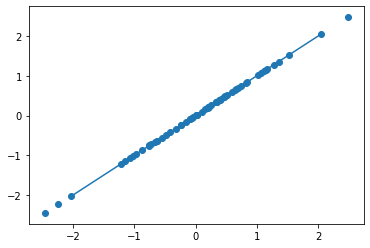

In [86]:
fig, ax = plt.subplots(1, 1)
ax.scatter(z, opt.position.numpy())
ax.plot(np.linspace(-2, 2), np.linspace(-2, 2))